In [1]:
#importamos los paquetes necesarios
import consultas as cst
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import time
import math
import datetime as dt

In [ ]:
#GROSS DEL MES POR PREDICCION 
query=f'''
WITH BASE AS (
SELECT * 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
WHERE A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_NOMBRE='ACTIVACION'
AND A.PERIODO_PROCESO_CODIGO=202307
),
BASE_CALIDAD AS (
SELECT * FROM (
SELECT  SUBSCRIBER_ID,FECHA_PRED,PREDICCION,
        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
FROM AGG_DL_PJ_QUALITY)
WHERE RN=1
)
SELECT B.PREDICCION,COUNT(*) 
FROM BASE A 
LEFT JOIN BASE_CALIDAD B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
GROUP BY B.PREDICCION
'''

In [ ]:
#GROSS DEL DIA POR PREDICCION ADECUAR EL FILTRO DE PREDICCION 
query=f'''
WITH BASE AS (
SELECT * 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
WHERE A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_NOMBRE='ACTIVACION'
AND A.PERIODO_PROCESO_CODIGO=202307
),
BASE_CALIDAD AS (
SELECT * FROM (
SELECT  SUBSCRIBER_ID,FECHA_PRED,PREDICCION,
        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
FROM AGG_DL_PJ_QUALITY)
WHERE RN=1
)
SELECT TO_NUMBER(TO_CHAR(A.FECHA_ALTA,'YYYYMMDD')),COUNT(*) 
FROM BASE A 
LEFT JOIN BASE_CALIDAD B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
WHERE B.PREDICCION=0
GROUP BY TO_NUMBER(TO_CHAR(A.FECHA_ALTA,'YYYYMMDD'))
ORDER BY TO_NUMBER(TO_CHAR(A.FECHA_ALTA,'YYYYMMDD')) 
'''

In [ ]:
#GROSS DEL DIA PICO CON ENFASIS EN EL DEALER 
query=f'''
WITH BASE AS (
SELECT * 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
WHERE A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_NOMBRE='ACTIVACION'
AND A.PERIODO_PROCESO_CODIGO=202307
),
BASE_CALIDAD AS (
SELECT * FROM (
SELECT  SUBSCRIBER_ID,FECHA_PRED,PREDICCION,
        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
FROM AGG_DL_PJ_QUALITY)
WHERE RN=1
)
SELECT  C.CONSULTOR_NOMBRE_NIVEL_8, 
        COUNT(*) 
FROM BASE A 
LEFT JOIN BASE_CALIDAD B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
LEFT JOIN DWH_BODEGA_WOM.DIM_CONSULTORES C ON A.CONSULTOR_DK=C.CONSULTOR_DK
WHERE B.PREDICCION=1
AND TO_NUMBER(TO_CHAR(A.FECHA_ALTA,'YYYYMMDD'))=20230731
GROUP BY  C.CONSULTOR_NOMBRE_NIVEL_8
ORDER BY COUNT(*) DESC
'''

In [ ]:
#top de dealers adecuar prediccion 

query=f'''
WITH BASE AS (
SELECT * 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
WHERE A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_NOMBRE='ACTIVACION'
AND A.PERIODO_PROCESO_CODIGO=202307
),
BASE_CALIDAD AS (
SELECT * FROM (
SELECT  SUBSCRIBER_ID,FECHA_PRED,PREDICCION,
        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
FROM AGG_DL_PJ_QUALITY)
WHERE RN=1
)
SELECT  C.CONSULTOR_NOMBRE_NIVEL_8, 
        COUNT(*) 
FROM BASE A 
LEFT JOIN BASE_CALIDAD B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
LEFT JOIN DWH_BODEGA_WOM.DIM_CONSULTORES C ON A.CONSULTOR_DK=C.CONSULTOR_DK
WHERE B.PREDICCION=1
GROUP BY  C.CONSULTOR_NOMBRE_NIVEL_8
ORDER BY COUNT(*) DESC
'''

In [ ]:
#POR TIPO DE PLAN TOTAL 
query=f'''
WITH BASE AS (
SELECT * 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
WHERE A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_NOMBRE='ACTIVACION'
AND A.PERIODO_PROCESO_CODIGO=202307
),
BASE_CALIDAD AS (
SELECT * FROM (
SELECT  SUBSCRIBER_ID,FECHA_PRED,PREDICCION,
        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
FROM AGG_DL_PJ_QUALITY)
WHERE RN=1
)
SELECT  D.PLAN_NOMBRE, 
        COUNT(*) 
FROM BASE A 
LEFT JOIN BASE_CALIDAD B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
LEFT JOIN DWH_BODEGA_WOM.DIM_CONSULTORES C ON A.CONSULTOR_DK=C.CONSULTOR_DK
LEFT JOIN DWH_BODEGA_WOM.DIM_PLANES D ON A.PLAN_COMERCIAL_DK=D.PLAN_COMERCIAL_DK
--WHERE B.PREDICCION=0
GROUP BY D.PLAN_NOMBRE
ORDER BY COUNT(*) DESC
'''

In [ ]:
# para donde se van los gestionables portacion 
query=f'''
WITH BASE AS (
SELECT * 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
WHERE A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_TIPO_NOMBRE='CHURN PORTACION'
AND A.PERIODO_PROCESO_CODIGO=202307
),
BASE_CALIDAD AS (
SELECT * FROM (
SELECT  SUBSCRIBER_ID,FECHA_PRED,PREDICCION,
        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
FROM AGG_DL_PJ_QUALITY)
WHERE RN=1
)
SELECT A.OPERADOR_PORTA_DESTINO,COUNT(*)
FROM BASE A 
LEFT JOIN BASE_CALIDAD B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
WHERE B.PREDICCION=0
GROUP BY A.OPERADOR_PORTA_DESTINO
'''


In [2]:
#QUERY QUE TRAE RECARGA DE LOS ULITMOS 30 DIAS ANTES DE PORTACION Y ANTIGUEDAD , TOCA JUNTAR CON LA BASE PARA INCLUIR LOS QUE NO 
query=f'''
WITH BASE AS (
SELECT *
FROM DWH_BODEGA_WOM.FCT_RECARGAS A
WHERE A.SERVICIO='Prepaid'
AND A.SUBSCRIBER_ID IN (
SELECT SUBSCRIBER_ID 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
WHERE A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_TIPO_NOMBRE='CHURN PORTACION'
AND A.PERIODO_PROCESO_CODIGO=202308
)),
BASE_FECHA_BAJA AS (
SELECT A.SUBSCRIBER_ID,A.FECHA_BAJA,ROUND(A.FECHA_BAJA-A.FECHA_ALTA,0) AS ANTIGUEDAD 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
WHERE A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_TIPO_NOMBRE='CHURN PORTACION'
AND A.PERIODO_PROCESO_CODIGO=202308
),
BASE_CALIDAD AS (
SELECT * FROM (
SELECT  SUBSCRIBER_ID,FECHA_PRED,PREDICCION,
        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
FROM AGG_DL_PJ_QUALITY)
WHERE RN=1
)

SELECT A.SUBSCRIBER_ID,
       SUM(A.VALOR_CARGA) AS VALOR_CARGA,
       COUNT(A.VALOR_CARGA) AS CANTIDAD_CARGA,
       ROUND(SUM(A.VALOR_CARGA)/COUNT(A.VALOR_CARGA),0) AS PROMEDIO 
FROM BASE A
LEFT JOIN BASE_FECHA_BAJA B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
LEFT JOIN BASE_CALIDAD C ON A.SUBSCRIBER_ID=C.SUBSCRIBER_ID
WHERE C.PREDICCION =0 
AND A.FECHA_RECARGA BETWEEN B.FECHA_BAJA-30 AND B.FECHA_BAJA 
GROUP BY A.SUBSCRIBER_ID
'''
recarga=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [3]:
recarga

,SUBSCRIBER_ID,VALOR_CARGA,CANTIDAD_CARGA,PROMEDIO
0,1195159708,33000,6,5500
1,1240970914,22000,6,3667
2,1112909928,4000,2,2000
3,1166913345,10000,2,5000
4,1115931918,3500,1,3500
...,...,...,...,...
2918,1433108055,3500,1,3500
2919,1247946306,6000,1,6000
2920,1290546287,6000,1,6000
2921,1186908646,24000,2,12000


In [20]:
recarga.describe()

,SUBSCRIBER_ID,VALOR_CARGA,CANTIDAD_CARGA,PROMEDIO
count,2.923000e+03,2923.000000,2923.000000,2923.000000
mean,1.390579e+09,13947.677044,2.399589,6639.452959
std,3.311137e+08,9465.607771,1.691999,4680.171159
min,1.112638e+09,1000.000000,1.000000,1000.000000
25%,1.203933e+09,6000.000000,1.000000,3500.000000
50%,1.311207e+09,12000.000000,2.000000,6000.000000
75%,1.396974e+09,21000.000000,3.000000,7000.000000
max,2.430166e+09,79500.000000,19.000000,43000.000000


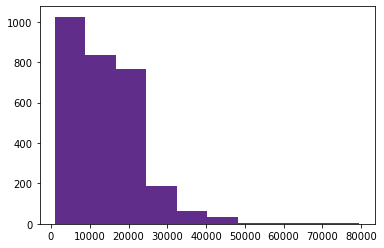

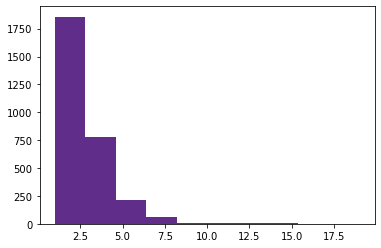

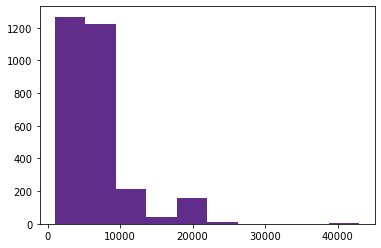

In [6]:
plt.hist(recarga['VALOR_CARGA'], color='#612D8A', alpha=1)
plt.show()
plt.hist(recarga['CANTIDAD_CARGA'], color='#612D8A', alpha=1)
plt.show()
plt.hist(recarga['PROMEDIO'], color='#612D8A', alpha=1)
plt.show()

In [3]:
#query que trae la base para luego hacer junte con recargas y separar oeprador 
query=f'''

WITH BASE AS (
SELECT A.SUBSCRIBER_ID,A.FECHA_BAJA,ROUND(A.FECHA_BAJA-A.FECHA_ALTA,0) AS ANTIGUEDAD,
A.OPERADOR_PORTA_DESTINO 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
WHERE A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_TIPO_NOMBRE='CHURN PORTACION'
AND A.PERIODO_PROCESO_CODIGO=202308
),
BASE_CALIDAD AS (
SELECT * FROM (
SELECT  SUBSCRIBER_ID,FECHA_PRED,PREDICCION,
        ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC) AS RN 
FROM AGG_DL_PJ_QUALITY)
WHERE RN=1
)
SELECT A.SUBSCRIBER_ID,
       A.OPERADOR_PORTA_DESTINO,
       A.ANTIGUEDAD,
       B.PREDICCION
FROM BASE A 
LEFT JOIN BASE_CALIDAD B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
'''
base=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
df_filtrado1 = base[base['PREDICCION'] == 0]
df_filtrado2 = base[base['PREDICCION'] == 1]

buena calidad


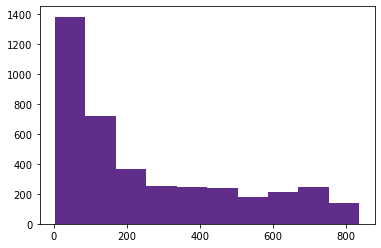

mala calidad


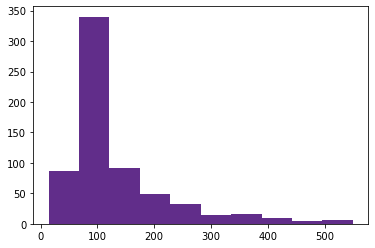

In [7]:
print("buena calidad")
plt.hist(df_filtrado1['ANTIGUEDAD'], color='#612D8A', alpha=1)
plt.show()
print("mala calidad")
plt.hist(df_filtrado2['ANTIGUEDAD'], color='#612D8A', alpha=1)
plt.show()

In [10]:
df_filtrado1.describe()


,SUBSCRIBER_ID,ANTIGUEDAD,PREDICCION
count,3.973000e+03,3973.000000,3973.0
mean,1.382261e+09,256.535615,0.0
std,3.280394e+08,238.424039,0.0
min,1.112638e+09,3.000000,0.0
25%,1.197040e+09,60.000000,0.0
50%,1.302843e+09,152.000000,0.0
75%,1.388605e+09,427.000000,0.0
max,2.430166e+09,836.000000,0.0


In [11]:
df_filtrado2.describe()

,SUBSCRIBER_ID,ANTIGUEDAD,PREDICCION
count,6.500000e+02,650.000000,650.0
mean,1.391512e+09,129.236923,1.0
std,1.597738e+08,94.990888,0.0
min,1.114991e+09,14.000000,1.0
25%,1.353306e+09,74.000000,1.0
50%,1.385288e+09,98.000000,1.0
75%,1.399276e+09,141.750000,1.0
max,2.417197e+09,550.000000,1.0


In [5]:
df_insumos=df_filtrado1.merge(recarga,left_on='SUBSCRIBER_ID',right_on='SUBSCRIBER_ID',how='left')
df_insumos=df_insumos.fillna(0)

In [11]:
df_insumos_no_recarga = df_insumos[df_insumos['VALOR_CARGA'] == 0]

In [12]:
df_insumos_no_recarga

,SUBSCRIBER_ID,OPERADOR_PORTA_DESTINO,ANTIGUEDAD,PREDICCION,VALOR_CARGA,CANTIDAD_CARGA,PROMEDIO
0,1112631676,COMCEL,818,0,0.0,0.0,0.0
1,1112634756,COMCEL,769,0,0.0,0.0,0.0
2,1112656338,TIGO,828,0,0.0,0.0,0.0
3,1112660592,COMCEL,805,0,0.0,0.0,0.0
4,1112663090,TELEFONICA,734,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
4081,2410578976,TELEFONICA,58,0,0.0,0.0,0.0
4088,2413249031,COMCEL,70,0,0.0,0.0,0.0
4095,2414878468,TIGO,69,0,0.0,0.0,0.0
4108,2418511404,TIGO,33,0,0.0,0.0,0.0


In [6]:
df_insumos_claro = df_insumos[df_insumos['OPERADOR_PORTA_DESTINO'] == 'COMCEL']
df_insumos_movistar = df_insumos[df_insumos['OPERADOR_PORTA_DESTINO'] == 'TELEFONICA']
df_insumos_tigo = df_insumos[df_insumos['OPERADOR_PORTA_DESTINO'] == 'TIGO']

In [7]:
df_insumos_claro.describe()

,SUBSCRIBER_ID,ANTIGUEDAD,PREDICCION,VALOR_CARGA,CANTIDAD_CARGA,PROMEDIO
count,1.485000e+03,1485.00000,1485.0,1485.000000,1485.000000,1485.000000
mean,1.407580e+09,223.63569,0.0,16029.714478,2.877441,5066.630303
std,3.198203e+08,227.21089,0.0,15365.300422,2.969941,4879.195961
min,1.112632e+09,0.00000,0.0,0.000000,0.000000,0.000000
25%,1.233033e+09,52.00000,0.0,3500.000000,1.000000,2000.000000
50%,1.342892e+09,122.00000,0.0,12000.000000,2.000000,4250.000000
75%,1.419688e+09,334.00000,0.0,24500.000000,4.000000,6000.000000
max,2.440310e+09,866.00000,0.0,86000.000000,32.000000,23000.000000


In [8]:
df_insumos_movistar.describe()

,SUBSCRIBER_ID,ANTIGUEDAD,PREDICCION,VALOR_CARGA,CANTIDAD_CARGA,PROMEDIO
count,1.494000e+03,1494.000000,1494.0,1494.000000,1494.000000,1494.000000
mean,1.411281e+09,250.409639,0.0,13362.505355,2.461178,4420.377510
std,3.407817e+08,247.322383,0.0,14953.191358,2.882291,4753.158339
min,1.112663e+09,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.208192e+09,54.000000,0.0,0.000000,0.000000,0.000000
50%,1.327389e+09,131.000000,0.0,9100.000000,2.000000,3500.000000
75%,1.421484e+09,412.000000,0.0,21500.000000,4.000000,6000.000000
max,2.441841e+09,868.000000,0.0,160000.000000,28.000000,30000.000000


In [9]:
df_insumos_tigo.describe()

,SUBSCRIBER_ID,ANTIGUEDAD,PREDICCION,VALOR_CARGA,CANTIDAD_CARGA,PROMEDIO
count,1.001000e+03,1001.000000,1001.0,1001.000000,1001.000000,1001.000000
mean,1.392085e+09,252.774226,0.0,13860.439560,2.478521,4595.786214
std,3.077094e+08,259.102877,0.0,15899.855138,2.893404,5583.784661
min,1.112656e+09,1.000000,0.0,0.000000,0.000000,0.000000
25%,1.202538e+09,39.000000,0.0,0.000000,0.000000,0.000000
50%,1.331363e+09,124.000000,0.0,9000.000000,2.000000,3500.000000
75%,1.458495e+09,451.000000,0.0,21000.000000,4.000000,6000.000000
max,2.444530e+09,859.000000,0.0,126000.000000,20.000000,63000.000000


In [2]:
query=f'''
WITH BASE AS (
SELECT *
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
WHERE A.SERVICIO='Prepaid'
AND A.MOVIMIENTO_TIPO_NOMBRE='CHURN PORTACION'
AND A.PERIODO_PROCESO_CODIGO=202307

),
BASE_CALIDAD AS (
SELECT * FROM (
SELECT SUBSCRIBER_ID,
       PREDICCION, 
       CONSULTOR_ALMACEN_NOMBRE,
       CONSULTOR_NOMBRE_NIVEL_8,
       ROW_NUMBER() OVER(PARTITION BY SUBSCRIBER_ID ORDER BY FECHA_PRED DESC ) AS RN 
FROM AGG_DL_PJ_QUALITY) WHERE RN=1 
)
SELECT A.SUBSCRIBER_ID,
       A.MSISDN, 
       C.CLIENTE_NIT_CEDULA,
       C.CLIENTE_NOMBRE,
       C.CLIENTE_CIUDAD,
       C.CLIENTE_EMAIL,
       B.CONSULTOR_ALMACEN_NOMBRE,
       B.CONSULTOR_NOMBRE_NIVEL_8,
       ROUND(A.FECHA_BAJA-A.FECHA_ALTA,0) AS ANTIGUEDAD  
FROM BASE A 
LEFT JOIN BASE_CALIDAD B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
LEFT JOIN DWH_BODEGA_WOM.DIM_CLIENTES C ON A.CLIENTE_DK=C.CLIENTE_DK
WHERE B.PREDICCION=1
AND B.CONSULTOR_NOMBRE_NIVEL_8='Ing Ayk Electronics S A S'
'''
dealers_ayk_jul=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
dealers_ayk_jul.describe()

,SUBSCRIBER_ID,ANTIGUEDAD
count,3.440000e+02,344.000000
mean,1.394870e+09,92.718023
std,1.983206e+07,30.423332
min,1.229687e+09,19.000000
25%,1.385288e+09,74.000000
50%,1.399266e+09,97.500000
75%,1.399277e+09,100.000000
max,1.435848e+09,281.000000


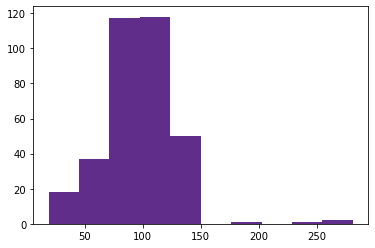

In [4]:
plt.hist(dealers_ayk_jul['ANTIGUEDAD'], color='#612D8A', alpha=1)
plt.show()

In [ ]:
dealers_ayk_jul.to_csv('ayk_portout_jul.csv')

In [3]:
dealers_ayk_jul

,SUBSCRIBER_ID,MSISDN,CLIENTE_NIT_CEDULA,CLIENTE_NOMBRE,CLIENTE_CIUDAD,CLIENTE_EMAIL,CONSULTOR_ALMACEN_NOMBRE,CONSULTOR_NOMBRE_NIVEL_8,ANTIGUEDAD
0,1435842223,3027597072,1110485045,Yuli Alexandra Montero Garcia,Ibagué,alexandra8819@hotmail.com,PRE Freelance - Ing Ayk Electronics S.A.S Ori...,Ing Ayk Electronics S A S,27
1,1435848142,3026537285,1123403814,Anyis Yojana Reyes Ortiz,Riohacha,AYOJANAREYES@GMAIL.COM,PRE Freelance - Ing Ayk Electronics S.A.S Ori...,Ing Ayk Electronics S A S,20
2,1435848393,3026537216,1002203367,Isaac Dario Angulo Montez,Cartagena,elsotanobarberia@gmail.com,PRE Freelance - Ing Ayk Electronics S.A.S Ori...,Ing Ayk Electronics S A S,20
3,1435848392,3026537278,1234092838,Kerwis Andres Gutierrez Marquez,Soledad,KERWINGUTIERREZ74@GMAIL.COM,PRE Freelance - Ing Ayk Electronics S.A.S Ori...,Ing Ayk Electronics S A S,20
4,1435848241,3026537282,72336348,Fabian Jose Obando Villa,Barranquilla,fabianobando5@gmail.com,PRE Freelance - Ing Ayk Electronics S.A.S Ori...,Ing Ayk Electronics S A S,20
...,...,...,...,...,...,...,...,...,...
339,1399272026,3026364582,1047367499,Keivin De Jesus Orozco Vargas,Arjona,Keivinorozco956@gmail.com,Tropas - Ing Ayk Electronics S.A.S Oriente,Ing Ayk Electronics S A S,68
340,1397912963,3026826310,3146846,Hector Mauricio Salazar Salazar,Zipaquirá,salazarmauricio376@gmail.com,PRE Freelance - Ing Ayk Electronics S.A.S Ori...,Ing Ayk Electronics S A S,97
341,1385285648,3026195464,52889296,Viviana Castañeda Fula,Bogotá D.C.,negrito1517@hotmail.com,Tropas - Ing Ayk Electronics S.A.S Oriente,Ing Ayk Electronics S A S,101
342,1399278161,3025508201,1007874719,Juan Carlos Benitez Murillo,Bogotá D.C.,Juansito123ngm@gmail.com,PRE Freelance - Ing Ayk Electronics S.A.S Ori...,Ing Ayk Electronics S A S,98


In [4]:
query=f'''
SELECT A.SUBSCRIBER_ID,
       A.SERVICIO,
       A.MSISDN,
       B.CLIENTE_NOMBRE,
       B.CLIENTE_EMAIL,
       D.PRODUCTO
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
LEFT JOIN DWH_BODEGA_WOM.DIM_CONSULTORES C ON A.CONSULTOR_DK=C.CONSULTOR_DK
LEFT JOIN DWH_BODEGA_WOM.DIM_CLIENTES B ON A.CLIENTE_DK=B.CLIENTE_DK
LEFT JOIN COMERCIAL_WOM.EQUIPOS D ON A.SUBSCRIBER_ID=D.SUBSCRIBER_ID
WHERE A.PERIODO_PROCESO_CODIGO=202307
AND  A.MOVIMIENTO_NOMBRE='ACTIVACION'
AND  C.CONSULTOR_CANAL_NOMBRE IN ('E-Dealers','Ventas Online')
'''
equipos_jul=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
equipos_jul.to_csv('equipos_jul.csv')